In [1]:
import gym
from gym import spaces

import numpy as np
import cv2
import matplotlib.pyplot as plt

from Agents import Agent
from IPython.display import clear_output

## Enviroment

In [2]:
from Enviroment import Enviroment

class CustomEnv(gym.Env):
    '''
    Оборочивание класса среды в среду gym
    '''
    metadata = {'render.modes': ['human']}

    def __init__(self, obstacle_turn: bool, Total_war: bool, num_obs: int, num_enemy: int, inp_dim: int,
                 size_obs, steps_limit, vizualaze = False, head_velocity = 0.01, rew_col = -70,
                 rew_win = 100, rew_defeat = -100):
        '''
        Инициализация класса среды
        :param obstacle_turn: (bool) Флаг генерации препятствий
        :param vizualaze: (bool) Флаг генерации препятствий
        :param Total_war: (bool) Флаг режима игры (с противником или без)
        :param steps_limit: (int) Максимальное количество действий в среде за одну игру
        '''

        self.log_koef = 50
        self.ang_Norm_coef = np.pi
        self.coords_Norm_coef = 500
        
        self.inp_dim = inp_dim
        
        self.rew_col = rew_col
        self.rew_win = rew_win
        self.rew_defeat = rew_defeat

        self.enviroment = Enviroment(obstacle_turn, vizualaze, Total_war,
                             head_velocity, num_obs, num_enemy, size_obs, steps_limit,
                             rew_col, rew_win, rew_defeat,epsilon = 100,sigma =30)

        self.enviroment.reset()

        self.action_space = spaces.Discrete(8)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(self.inp_dim, self.inp_dim, 3), dtype=np.uint8)
       
    
    def step(self, action):
        """
        Метод осуществления шага в среде
        :param action: (int) направление движения в среде
        :return: dict_state, reward, not done, {}: состояние, реворд, флаг терминального состояния, информация о среде
        """
        state, reward, done, numstep = self.enviroment.step(int(action))

        x2 = state.posRobot[0]
        y2 = state.posRobot[1]
    
        x4 = state.target[0,0]
        y4 = state.target[0,1]
        
        
        f2 =  state.target[0,2]
        f2 = np.deg2rad(f2)
        
        Ax4, Ay4 = -np.cos(f2), np.sin(f2)
        Bx24, By24 = x2 - x4, y2 - y4

        dist = - np.sqrt(np.abs((x2-x4)**2 + (y2-y4)**2))
        phy = (Ax4*Bx24 + Ay4*By24)/(np.sqrt(Ax4**2 + Ay4**2) * np.sqrt(Bx24**2 + By24**2))
        reward_l = phy*(dist+500) * 0.01 * (not done) + np.round(reward, 2).sum()

        return state.img, reward_l, done, {}
        
    def reset(self):
        '''
        Метод обновления игры
        :return: dict_state: состояние
        '''
        state = self.enviroment.reset()

        return state.img

    def render(self, model, num_gifs=1):
        '''
        Метод вывода информации об игре
        :param mode:
        :return:
        '''
        for i in range(num_gifs):
            
            images = []
            obs = self.reset()
            img = obs['img']# env.render(mode='rgb_array')
            done = False
                
            height, width, layers = img.shape
            size = (width,height)
            out = cv2.VideoWriter(f"video{i}.avi",cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            out.write(img)
            while not done:

                action, _ = model.predict(obs)
                print(action)
                obs, _, done ,_ = self.step(int(action))
                img = obs['img']
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                out.write(img)
            out.release()
    
    def get_statistic(self, model, num_games):
        collision = 0
        win = 0
        destroyed = 0
        loss = 0
        for i in range(num_games):
            obs = self.reset()
            done = False
            while not done:
                action, _ = model.predict(obs)
                obs, reward, done ,_ = self.step(int(action))
                
            if reward == -30:#win
                collision+=1
            elif reward == 100:# loss
                win +=1
            elif reward == -100:# loss
                destroyed +=1
            else:    #not_achieved
                loss+=1
        
        print("Win: ",win/num_games)
        print("destroyed: ", destroyed/num_games)
        print("loss: ",loss/num_games)
        print("collision: ",collision/num_games)


pygame 2.1.0 (SDL 2.0.16, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Init

In [3]:
env = CustomEnv(obstacle_turn = True,
            vizualaze     = False, 
            Total_war     = True,
            head_velocity = 0.005,#0.005
            num_obs       = 1, 
            num_enemy     = 1, 
            size_obs      = [50, 60],
            rew_col       = -70,
            rew_win       = 100,
            inp_dim       = 500,
            rew_defeat    = -100,
            steps_limit   = 2000)

In [4]:
N = 100
batch_size = 25
n_epochs = 2
alpha = 0.001
n_games = 10000

In [5]:
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
              alpha=alpha, n_epochs=n_epochs,
              input_dims=env.observation_space.shape)

In [6]:
best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation = env.reset()
    observation = np.reshape(observation, (3, 500, 500))
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        
        observation_, reward, done, info = env.step(action)
        observation_ = np.reshape(observation_, (3, 500, 500))
        
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
        
    if not bool(i%10):clear_output()
    print('episode ', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
          'time step', n_steps, 'learning_steps', learn_iters)

episode  9990 score 283.5 avg score -97.2 time step 523505 learning_steps 5235
episode  9991 score 30.2 avg score -92.0 time step 523553 learning_steps 5235
episode  9992 score -370.5 avg score -94.8 time step 523586 learning_steps 5235
episode  9993 score -70.9 avg score -95.8 time step 523624 learning_steps 5236
episode  9994 score -46.0 avg score -96.0 time step 523668 learning_steps 5236
episode  9995 score -433.3 avg score -99.6 time step 523742 learning_steps 5237
episode  9996 score -71.4 avg score -99.3 time step 523754 learning_steps 5237
episode  9997 score -127.6 avg score -98.9 time step 523777 learning_steps 5237
episode  9998 score -351.9 avg score -101.6 time step 523817 learning_steps 5238
episode  9999 score -642.6 avg score -103.1 time step 523889 learning_steps 5238


In [29]:
def plot_learning_curve(scores, x, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.savefig(figure_file, dpi=100)

ValueError: x and y must have same first dimension, but have shapes (10000,) and (10018,)

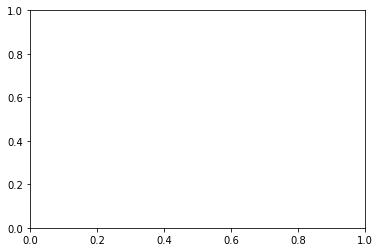

In [30]:
x = [i + 1 for i in range(n_games)]
plot_learning_curve( score_history,x, 'PPO.png')

In [ ]:
agent.load_models()

In [ ]:
env = CustomEnv(obstacle_turn = True,
            vizualaze     = True, 
            Total_war     = True,
            head_velocity = 0.005,#0.005
            num_obs       = 1, 
            num_enemy     = 1, 
            size_obs      = [50, 60],
            rew_col       = -70,
            rew_win       = 100,
            inp_dim       = 500,
            rew_defeat    = -100,
            steps_limit   = 2000)

In [ ]:
for i in range(1):
    observation = env.reset()
    observation = np.reshape(observation, (3, 500, 500))
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        
        observation_, reward, done, info = env.step(action)
        observation_ = np.reshape(observation_, (3, 500, 500))
        
        n_steps += 1
        score += reward
        # agent.remember(observation, action, prob, val, reward, done)
        # if n_steps % N == 0:
            # agent.learn()
            # learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    # if avg_score > best_score:
    #     best_score = avg_score
    #     agent.save_models()
        
    # if not bool(i%10):clear_output()
    print('episode ', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
          'time step', n_steps, 'learning_steps', learn_iters)